In [15]:
%%capture
!pip install setuptools wheel
!pip install "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use("Solarize_Light2")

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exploratory Data Analysis 

In [15]:
def preprocess_data(data):
    data = data.set_index('Date')
    data['TP'] = data.apply(
        lambda x: np.mean(x[['High', 'Low', 'Close']]), axis=1
    )
    data['target'] = data.TP.shift(-1)
    data = data.dropna()
    data = data.drop(columns=['TP'])
    return data

appl_data = preprocess_data(pd.read_csv("data/APPL_raw_data.csv"))
mmm_data = preprocess_data(pd.read_csv("data/MMM_raw_data.csv"))
wdc_data = preprocess_data(pd.read_csv("data/WDC_raw_data.csv"))

appl_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,CPIAUCSL,FEDFUNDS,target
Date,,,,,,,,,,
1997-01-02,0.161046,0.161999,0.158188,0.160093,143113600,0.0,0.0,159.4,5.25,0.165176
1997-01-03,0.161046,0.169623,0.160093,0.165811,119716800,0.0,0.0,159.4,5.25,0.135873
1997-01-06,0.134364,0.139843,0.131506,0.136270,1882832000,0.0,0.0,159.4,5.25,0.135317
1997-01-07,0.138176,0.139129,0.133411,0.133411,976931200,0.0,0.0,159.4,5.25,0.135635
1997-01-08,0.139128,0.140082,0.132458,0.134364,1100131200,0.0,0.0,159.4,5.25,0.134999


In [38]:
wdc_data.corr()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,CPIAUCSL,FEDFUNDS,target
Open,1.000000,0.999758,0.999712,0.999456,0.119444,0.077852,-0.004783,0.779047,-0.544516,0.998882
High,0.999758,1.000000,0.999671,0.999730,0.125990,0.078037,-0.004545,0.780459,-0.544575,0.999171
Low,0.999712,0.999671,1.000000,0.999781,0.112713,0.077614,-0.004969,0.778165,-0.544959,0.999230
Close,0.999456,0.999730,0.999781,1.000000,0.119275,0.077879,-0.004778,0.779401,-0.545098,0.999451
Volume,0.119444,0.125990,0.112713,0.119275,1.000000,0.017765,0.001330,0.312150,-0.239036,0.119073
Dividends,0.077852,0.078037,0.077614,0.077879,0.017765,1.000000,-0.000843,0.057657,-0.038619,0.078512
Stock Splits,-0.004783,-0.004545,-0.004969,-0.004778,0.001330,-0.000843,1.000000,-0.020124,0.020297,-0.004465
CPIAUCSL,0.779047,0.780459,0.778165,0.779401,0.312150,0.057657,-0.020124,1.000000,-0.689550,0.779383
FEDFUNDS,-0.544516,-0.544575,-0.544959,-0.545098,-0.239036,-0.038619,0.020297,-0.689550,1.000000,-0.545379
target,0.998882,0.999171,0.999230,0.999451,0.119073,0.078512,-0.004465,0.779383,-0.545379,1.000000


array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'High'}>,
        <AxesSubplot:title={'center':'Low'}>],
       [<AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'Dividends'}>],
       [<AxesSubplot:title={'center':'Stock Splits'}>,
        <AxesSubplot:title={'center':'CPIAUCSL'}>,
        <AxesSubplot:title={'center':'FEDFUNDS'}>],
       [<AxesSubplot:title={'center':'target'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

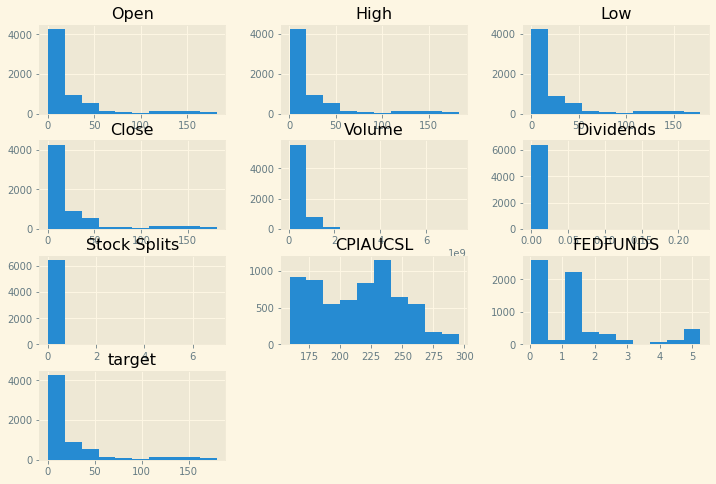

In [37]:
appl_data.hist(figsize=(12, 8))

## Data Prepartion

In order not to overfit our model, we split the data into train and test linearly by timeline instead of sampling. 

In [20]:
DAYS_FOR_TESTING = 60

def split_data(data):    
    train = data.iloc[:-DAYS_FOR_TESTING, :]
    test = data.iloc[-DAYS_FOR_TESTING:, :]
    return train, test

def autogluon_train(data):
    train, test = split_data(data)
    predictor = TabularPredictor(label='target', eval_metric='root_mean_squared_error')
                    .fit(train, time_limit=600, presets='best_quality')
    predictor.fit_summary()
    return predictor, train, test

appl_predictor, appl_train, appl_test = autogluon_train(appl_data)

In [122]:
appl_predictor, appl_train, appl_test = autogluon_train(appl_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20220830_232015/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220830_232015/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    6397
Train Data Columns: 9
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (180.12130413520288, 0.0995818702463001, 22.70614, 37.53803)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting 

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -0.729832       1.294480  245.344897                0.000982           0.653287            2       True         12
1     ExtraTreesMSE_BAG_L1  -0.735487       0.302980    2.537534                0.302980           2.537534            1       True          7
2      WeightedEnsemble_L3  -0.739901      14.559024  425.705192                0.000722           0.315919            3       True         19
3     ExtraTreesMSE_BAG_L2  -0.748789      11.270580  336.879717                0.314170           4.344413            2       True         17
4   RandomForestMSE_BAG_L2  -0.751977      11.147166  343.465732                0.190756          10.930429            2       True         15
5   RandomForestMSE_BAG_L1  -0.754784       0.179697    4.390397                

In [124]:
mmm_predictor, mmm_train, mmm_test = autogluon_train(mmm_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20220830_233535/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220830_233535/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    6397
Train Data Columns: 9
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (219.88118402663522, 18.098503739818508, 80.94533, 54.45773)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting 

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -1.131437       6.036090  350.765211                0.000694           0.697978            2       True         12
1      WeightedEnsemble_L3  -1.153669       8.066136  583.547282                0.000997           0.383597            3       True         19
2     ExtraTreesMSE_BAG_L1  -1.156370       0.305741    2.637789                0.305741           2.637789            1       True          7
3     ExtraTreesMSE_BAG_L2  -1.162694       6.696258  383.045546                0.332224           4.349378            2       True         17
4   RandomForestMSE_BAG_L2  -1.174798       6.550387  388.319975                0.186354           9.623806            2       True         15
5   RandomForestMSE_BAG_L1  -1.178558       0.191829    4.596997                

In [128]:
wdc_predictor, wdc_train, wdc_test = autogluon_train(wdc_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20220830_234927/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220830_234927/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    6397
Train Data Columns: 9
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (96.87888380986651, 1.6323559059794046, 31.93531, 25.08138)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting A

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -0.848880       0.956027  121.240866                0.001075           0.740108            2       True         12
1      WeightedEnsemble_L3  -0.860028       6.148181  552.317189                0.000723           0.323510            3       True         19
2          LightGBM_BAG_L1  -0.867906       0.074633   17.806002                0.074633          17.806002            1       True          4
3           XGBoost_BAG_L1  -0.871858       0.080555   15.956267                0.080555          15.956267            1       True          9
4     ExtraTreesMSE_BAG_L1  -0.873432       0.315021    2.632390                0.315021           2.632390            1       True          7
5     ExtraTreesMSE_BAG_L2  -0.875804       5.414494  365.263935                

In [26]:
def get_prediction(predictor, test_data, ticker):
    result = pd.DataFrame(test_data)
    result['prediction'] = predictor.predict(test_data)
    result.plot(y=['target', 'prediction'], kind='line', figsize=(12,8))
    plt.title(f"{ticker} Stock Price Vs. Prediction using Autogluon", size=12)
    plt.gcf().autofmt_xdate()
    return result

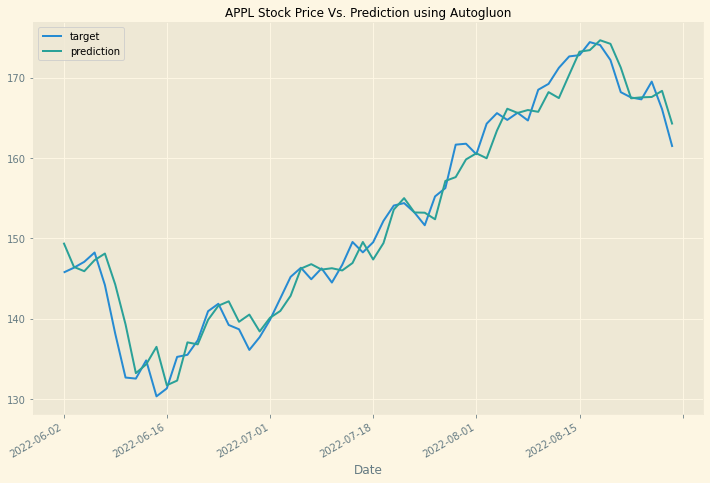

In [131]:
appl_result = get_prediction(appl_predictor, appl_test, "APPL")

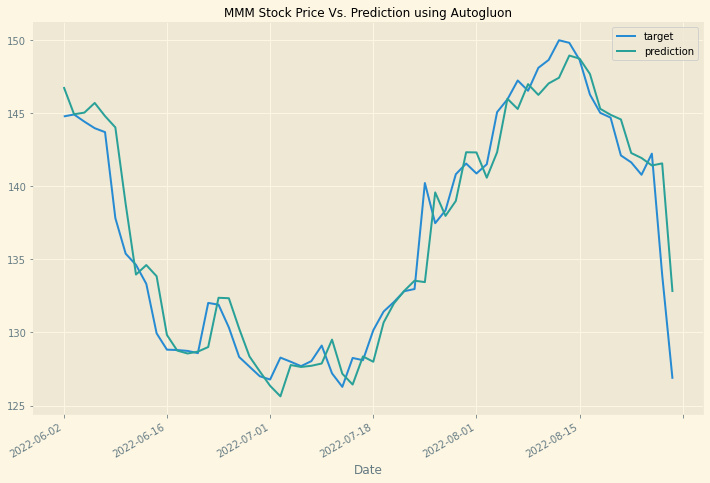

In [132]:
mmm_result = get_prediction(mmm_predictor, mmm_test, "MMM")

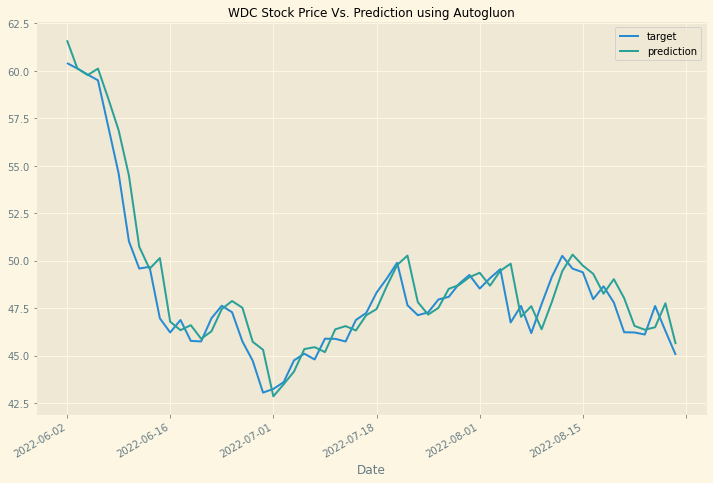

In [133]:
wdc_result = get_prediction(wdc_predictor, wdc_test, "WDC")

In [10]:
def print_eval_metrics(appl_result, mmm_result, wdc_result):
    results = [appl_result, mmm_result, wdc_result]
    mae_list = [mean_absolute_error(result['target'], result['prediction']) for result in results]
    rmse_list = [mean_squared_error(result['target'], result['prediction'], squared=False) for result in results]
    return pd.DataFrame({
        "Stock": ["AAPL", "MMM", "WDC"],
        'MAE': mae_list,
        "RMSE": rmse_list,
    })

In [134]:
print_eval_metrics(appl_result, mmm_result, wdc_result)

,Stock,MAE,RMSE
0,AAPL,1.821102,2.409850
1,MMM,1.521855,2.252094
2,WDC,0.867268,1.180547


## Traning Evaluation

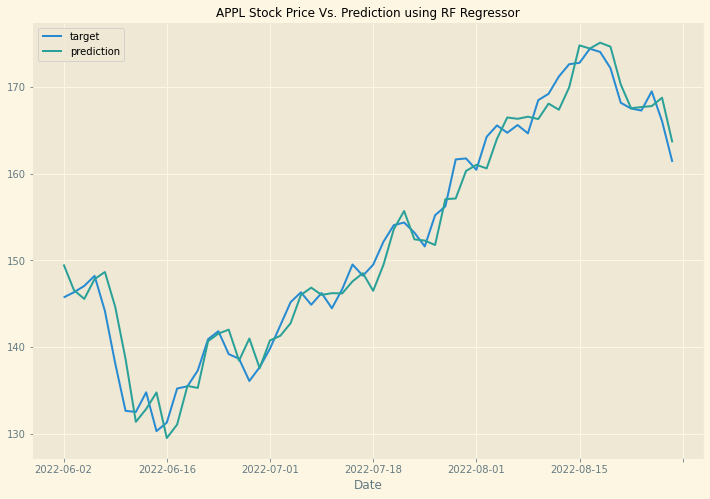

In [7]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_predict(data, ticker):
    train, test = split_data(data)
    x_train_rf, y_train_rf = train.loc[:, train.columns != 'target'], train['target']
    x_test_rf, y_test_rf = test.loc[:, test.columns != 'target'], test['target']
    
    regressor_rf = RandomForestRegressor(n_estimators=800)
    regressor_rf.fit(x_train_rf, y_train_rf)
    prediction_rf = regressor_rf.predict(x_test_rf)
    
    result_rf = pd.DataFrame(y_test_rf)
    result_rf['prediction'] = prediction_rf
    result_rf.plot(figsize=(12,8))
    plt.title(f"{ticker} Stock Price Vs. Prediction using RF Regressor", size=12)
    return result_rf

appl_result_rf = random_forest_predict(appl_data, "APPL")

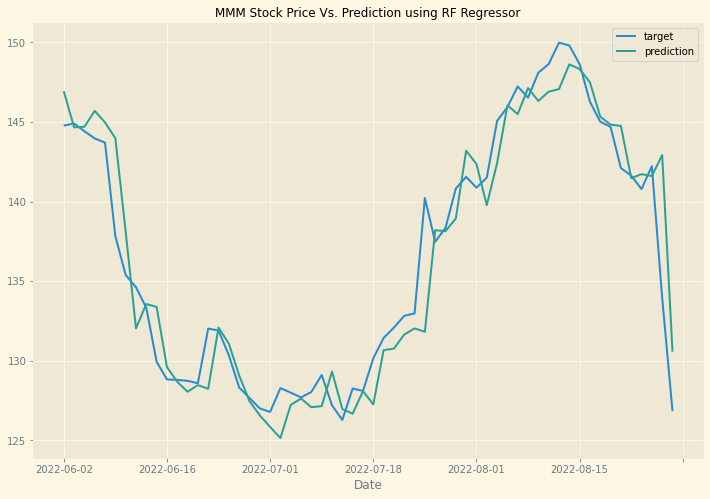

In [8]:
mmm_result_rf = random_forest_predict(mmm_data, "MMM")

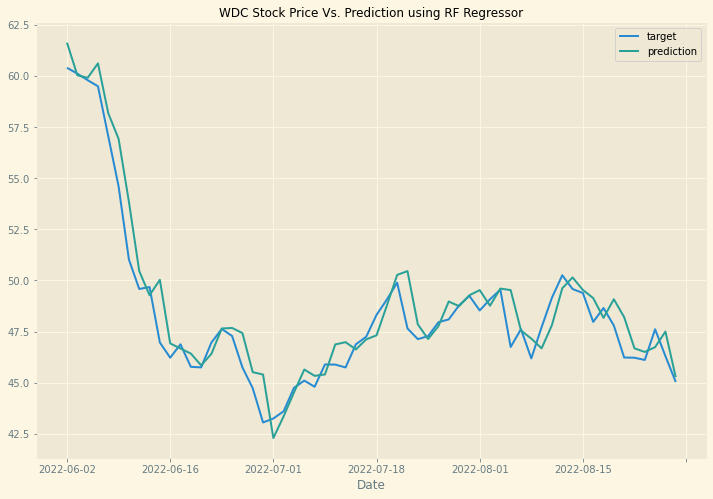

In [9]:
wdc_result_rf = random_forest_predict(wdc_data, "WDC")

In [11]:
print_eval_metrics(appl_result_rf, mmm_result_rf, wdc_result_rf)

,Stock,MAE,RMSE
0,AAPL,1.872423,2.424297
1,MMM,1.595721,2.380128
2,WDC,0.827676,1.127519


## Feature Engineering

In [16]:
appl_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,CPIAUCSL,FEDFUNDS,target
Date,,,,,,,,,,
1997-01-02,0.161046,0.161999,0.158188,0.160093,143113600,0.0,0.0,159.4,5.25,0.165176
1997-01-03,0.161046,0.169623,0.160093,0.165811,119716800,0.0,0.0,159.4,5.25,0.135873
1997-01-06,0.134364,0.139843,0.131506,0.136270,1882832000,0.0,0.0,159.4,5.25,0.135317
1997-01-07,0.138176,0.139129,0.133411,0.133411,976931200,0.0,0.0,159.4,5.25,0.135635
1997-01-08,0.139128,0.140082,0.132458,0.134364,1100131200,0.0,0.0,159.4,5.25,0.134999


In [22]:
BACKTRACK_DAYS = 7

def add_backtracking_features(data):
    data_enriched = data.copy()
    # Add backtracing data for each data entry
    for i in range (BACKTRACK_DAYS, 0, -1):
        data_enriched[f't-{i}'] = data_enriched.target.shift(i)

    # Add moving Avg of 2 weeks
    data_enriched["rolling"] = data_enriched.target.rolling(window=14).mean()
    return data_enriched.dropna()

appl_enriched = add_backtracking_features(appl_data)
mmm_enriched = add_backtracking_features(mmm_data)
wdc_enriched = add_backtracking_features(wdc_data)

appl_enriched.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,CPIAUCSL,FEDFUNDS,target,t-7,t-6,t-5,t-4,t-3,t-2,t-1,rolling
Date,,,,,,,,,,,,,,,,,,
1997-01-21,0.129600,0.131505,0.128647,0.131505,284827200,0.0,0.0,159.4,5.25,0.131347,0.139129,0.137223,0.133094,0.128329,0.128329,0.129123,0.130553,0.135833
1997-01-22,0.132458,0.133411,0.129600,0.131029,205620800,0.0,0.0,159.4,5.25,0.131505,0.137223,0.133094,0.128329,0.128329,0.129123,0.130553,0.131347,0.133428
1997-01-23,0.131505,0.132458,0.130553,0.131505,172345600,0.0,0.0,159.4,5.25,0.129600,0.133094,0.128329,0.128329,0.129123,0.130553,0.131347,0.131505,0.132980
1997-01-24,0.131505,0.131505,0.128647,0.128647,188283200,0.0,0.0,159.4,5.25,0.128329,0.128329,0.128329,0.129123,0.130553,0.131347,0.131505,0.129600,0.132481
1997-01-27,0.130553,0.131505,0.126741,0.126741,214043200,0.0,0.0,159.4,5.25,0.127376,0.128329,0.129123,0.130553,0.131347,0.131505,0.129600,0.128329,0.131891


In [23]:
appl_predictor_en, appl_train_en, appl_test_en = autogluon_train(appl_enriched)

No path specified. Models will be saved in: "AutogluonModels/ag-20220831_005713/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220831_005713/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    6384
Train Data Columns: 17
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (180.12130413520288, 0.0995818702463001, 22.7521, 37.5624)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting A

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -0.734538       0.861197  221.187128                0.000758           0.427334            2       True          9
1     ExtraTreesMSE_BAG_L1  -0.739333       0.374636    4.178409                0.374636           4.178409            1       True          7
2   RandomForestMSE_BAG_L1  -0.746910       0.332480   14.682250                0.332480          14.682250            1       True          5
3      WeightedEnsemble_L3  -0.759329      19.560344  485.301387                0.001039           0.249228            3       True         14
4   RandomForestMSE_BAG_L2  -0.762977      19.423652  412.524784                0.340159          23.411160            2       True         12
5          LightGBM_BAG_L1  -0.829055       0.060292   19.364524                

In [28]:
mmm_predictor_en, mmm_train_en, mmm_test_en = autogluon_train(mmm_enriched)

No path specified. Models will be saved in: "AutogluonModels/ag-20220831_011240/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220831_011240/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    6384
Train Data Columns: 17
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (219.88118402663522, 18.098503739818508, 81.06591, 54.44748)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -1.135324       8.123906  399.430106                0.001126           0.828578            2       True          9
1      WeightedEnsemble_L3  -1.147116      11.728602  531.303024                0.000742           0.290602            3       True         15
2     ExtraTreesMSE_BAG_L2  -1.156113      11.203294  403.581421                0.343339           4.960089            2       True         14
3     ExtraTreesMSE_BAG_L1  -1.156409       0.336128    3.841197                0.336128           3.841197            1       True          7
4   RandomForestMSE_BAG_L1  -1.166122       0.342712   13.567322                0.342712          13.567322            1       True          5
5   RandomForestMSE_BAG_L2  -1.168805      11.206198  419.227741                

In [29]:
wdc_predictor_en, wdc_train_en, wdc_test_en = autogluon_train(wdc_enriched)

No path specified. Models will be saved in: "AutogluonModels/ag-20220831_012431/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220831_012431/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    6384
Train Data Columns: 17
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (96.87888380986651, 1.6323559059794046, 31.94618, 25.10557)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting 

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -0.856932       4.294269  188.767275                0.001667           0.687851            2       True         11
1      WeightedEnsemble_L3  -0.872316       9.659487  558.619342                0.000799           0.272412            3       True         17
2          LightGBM_BAG_L1  -0.873841       0.087451   19.726708                0.087451          19.726708            1       True          4
3     ExtraTreesMSE_BAG_L2  -0.877812       8.300194  394.053850                0.352458           5.455928            2       True         16
4           XGBoost_BAG_L1  -0.878538       0.082511   19.846333                0.082511          19.846333            1       True          9
5     ExtraTreesMSE_BAG_L1  -0.880067       0.344221    3.732222                

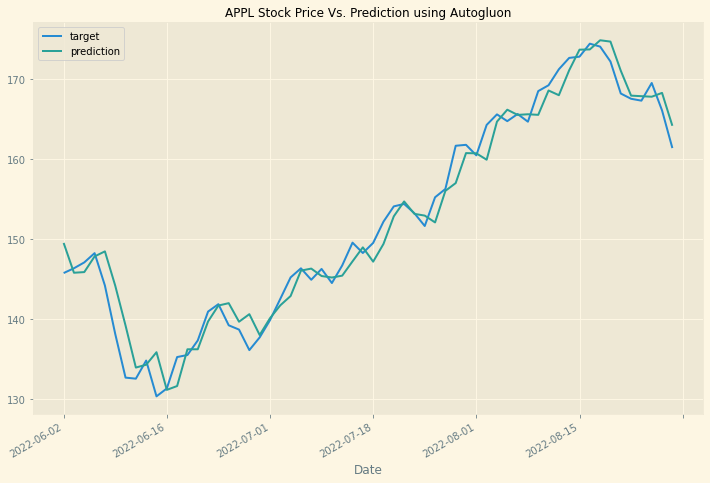

In [30]:
appl_result_en = get_prediction(appl_predictor_en, appl_test_en, "APPL")

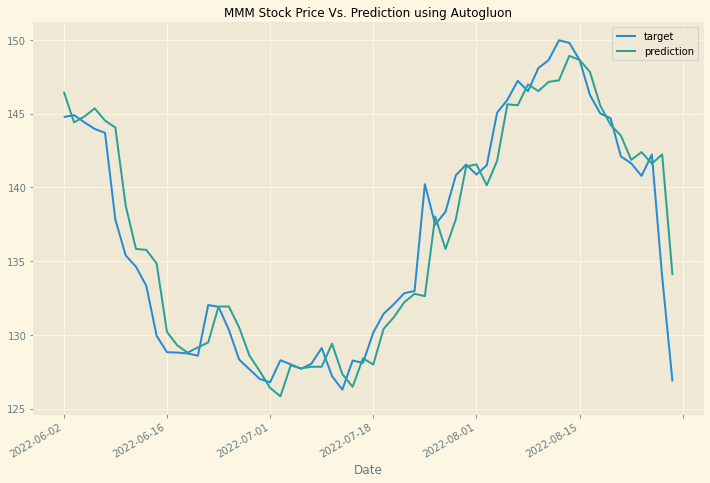

In [31]:
mmm_result_en = get_prediction(mmm_predictor_en, mmm_test_en, "MMM")

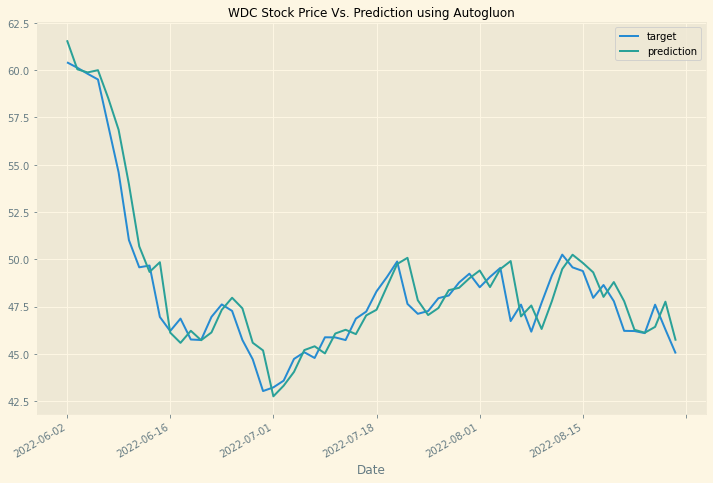

In [32]:
wdc_result_en = get_prediction(wdc_predictor_en, wdc_test_en, "WDC")

In [33]:
print_eval_metrics(appl_result_en, mmm_result_en, wdc_result_en)

,Stock,MAE,RMSE
0,AAPL,1.761104,2.362705
1,MMM,1.632438,2.448547
2,WDC,0.857069,1.137818
